# Somoclu SOM Summarizer Demo

**Author:** Ziang Yan, Sam Schmidt

**Last successfully run:** June 16, 2023


This notebook shows a quick demonstration of the use of the `SOMocluSummarizer` summarization module.  Algorithmically, this module is not very different from the NZDir estimator/summarizer.  NZDir operates by finding neighboring photometric points around spectroscopic objects.  SOMocluSummarizer takes a large training set of data in the `Inform_SOMocluUmmarizer` stage and trains a self-organized map (SOM) (using code from the `somoclu` package available at: https://github.com/peterwittek/somoclu/).  Once the SOM is set up, the "best match unit" are determined for both the photometric/unknown data and a set of spectroscopic data with known redshifts.  For each SOM cell, the algorithm constructs a histogram using the spectroscopic members mapped to that cell, and weights these by the number of photometric galaxies in that cell.  Both the photometric and spectroscopic datasets can also employ an optional weight per-galaxy. <br>

The summarizer also identifies SOM cells that contain photometric data but do not contain and galaxies with a measured spec-z, and thus do not have an obvious redshift estimate.  It writes out the (raveled) SOM cell indices that contain "uncovered"/uncalibratable data to the file specified by the `uncovered_cell_file` option as a list of integers.  The cellIDs and galaxy/objIDs for all photometric galaxies will be written out to the file specified by the `cellid_output` parameter.  Any galaxies in these cells should really be removed, and thus some iteration may be necessary in defining bin membership by looking at the properties of objects in these uncovered cells before a final N(z) is estimated, as otherwise a bias may be present.<br>

The shape and number of cells used in constructing the SOM affects performance, as do several tuning parameters.  This paper, http://www.giscience2010.org/pdfs/paper_230.pdf gives a rough guideline that the number of cells should be of the order ~ 5 x sqrt (number of data rows x number of column rows), though this is a rough guide.  Some studies have found a 2D SOM that is more elongated in one direction to be preferential, while others claim that a square layout is optimal, the user can set the number of cells in each SOM dimension via the `n_rows` and `n_cols` parameters.  For more discussion on SOMs see the Appendices of this KiDS paper:  http://arxiv.org/abs/1909.09632.

As with the other RAIL summarizers, we bootstrap the spectroscopic sample and return N bootstraps in an ensemble, along with a single fiducial N(z) estimate.<br>

More specific details of the algorithm's set up will be described in the course of this notebook, along with some illustrative plots.

Let's set up our dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import rail
import os
import qp
import tables_io
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.utils.path_utils import find_rail_file


Next, let's set up the Data Store, so that our RAIL module will know where to fetch data:

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

First, let's grab some data files.  For the SOM, we will want to train on a fairly large, representative set that encompasses all of our expected data.  We'll grab a larger data file than we typically use in our demos to ensure that we construct a meaningful SOM.

This data consists of ~150,000 galaxies from a single healpix pixel of the comsoDC2 truth catalog with mock 10-year magnitude errors added.  It is cut at a relatively bright i<23.5 magnitudes in order to concentrate on galaxies with particularly high S/N rates.

In [3]:
training_file = "./healpix_10326_bright_data.hdf5"

if not os.path.exists(training_file):
  os.system('curl -O https://portal.nersc.gov/cfs/lsst/PZ/healpix_10326_bright_data.hdf5')

In [4]:
# way to get big data file
training_data = DS.read_file("training_data", TableHandle, training_file)

Now, let's set up the inform stage for our summarizer

In [5]:
from rail.estimation.algos.somoclu_som import *

We need to define all of our necessary initialization params, which includes the following:
- `name` (str): the name of our estimator, as utilized by ceci
- `model` (str): the name for the model file containing the SOM and associated parameters that will be written by this stage
- `hdf5_groupname` (str): name of the hdf5 group (if any) where the photometric data resides in the training file
- `n_rows` (int): the number of dimensions in the y-direction for our 2D SOM
- `m_columns` (int): the number of dimensions in the x-direction for our 2D SOM
- `som_iterations` (int): the number of iteration steps during SOM training.  SOMs can take a while to converge, so we will use a fairly large number of 500,000 iterations.
- `std_coeff` (float): the "radius" of how far to spread changes in the SOM 
- `som_learning_rate` (float): a number between 0 and 1 that controls how quickly the weighting function decreases.  SOM's are not guaranteed to converge mathematically, and so this parameter tunes how the response drops per iteration.  A typical values we might use might be between 0.5 and 0.75.
- `column_usage` (str):  this value determines what values will be used to construct the SOM, valid choices are `colors`, `magandcolors`, and `columns`.  If set to `colors`, the code will take adjacent columns as specified in `usecols` to construct colors and use those as SOM inputs.  If set to `magandcolors` it will use the single column specfied by `ref_column_name` and the aforementioned colors to construct the SOM.  If set to `columns` then it will simply take each of the columns in `usecols` with no modification.  So, if a user wants to use K magnitudes and L colors, they can precompute the colors and specify all names in `usecols`.  NOTE: accompanying `usecols` you must have a `nondetect_val` dictionary that lists the replacement values for any non-detection-valued entries for each column, see the code for an example dictionary.  WE will set `column_usage` to colors and use only colors in this example notebook.

In [6]:
grid_type = 'hexagonal'
inform_dict = dict(model='output_SOMoclu_model.pkl', hdf5_groupname='photometry',
                   n_rows=71, n_columns=71, 
                   gridtype = grid_type,
                   std_coeff=12.0, som_learning_rate=0.75,
                   column_usage='colors')

In [7]:
inform_som = SOMocluInformer.make_stage(name='inform_som', **inform_dict)

Let's run our stage, which will write out a file called `output_SOM_model.pkl`

**NOTE for those using M1 Macs:** you may get an error like `wrap_train not found` when running the inform stage in the cell just below here.  If so, this can be solved by reinstalling somoclu from conda rather than pip with the command:
```
conda install -c conda-forge somoclu
```

In [8]:
%%time
inform_som.inform(training_data)

Inserting handle into data store.  model_inform_som: inprogress_output_SOMoclu_model.pkl, inform_som
CPU times: user 10min 52s, sys: 537 ms, total: 10min 53s
Wall time: 9.3 s


Running the stage took ~1 minute wall time on a desktop Mac and ~3.5 minutes on NERSC Jupyter lab.  Remember, however, that in many production cases we would likely load a pre-trained SOM specifically tuned to the given dataset, and this inform stage would not be run each time.

Let's read in the SOM model file, which contains our som model and several of the parameters used in constructing the SOM, and needed by our summarization model.

In [9]:
with open("output_SOMoclu_model.pkl", "rb") as f:
    model = pickle.load(f)

In [10]:
model.keys()

dict_keys(['som', 'usecols', 'ref_column', 'n_rows', 'n_columns', 'column_usage'])

To visualize our SOM, let's calculate the cell occupation of our training sample, as well as the mean redshift of the galaxies in each cell.  The SOM took colors as inputs, so we will need to construct the colors for our training set galaxie:

In [11]:
bands = ['u','g','r','i','z','y']
bandnames = [f"mag_{band}_lsst" for band in bands]
ngal = len(training_data.data['photometry']['mag_i_lsst'])
colors = np.zeros([5, ngal])
for i in range(5):
    colors[i] = training_data.data['photometry'][bandnames[i]] - training_data.data['photometry'][bandnames[i+1]]

We can calculate the best SOM cell using the get_bmus() function defined in somoclu_som.py, which will return the 2D SOM coordinates for each galaxy, and then use these for our visualizations (this step might take a while):

In [12]:
SOM = model['som']
bmu_coordinates = get_bmus(SOM, colors.T).T

In [13]:
meanszs = np.zeros_like(SOM.umatrix)
cellocc = np.zeros_like(SOM.umatrix)

for i in range(training_data.data['photometry']['redshift'].size):
    bmu_x, bmu_y = bmu_coordinates.T[i]
    meanszs[bmu_x, bmu_y] += training_data.data['photometry']['redshift'][i]
    cellocc[bmu_x, bmu_y] += 1
meanszs /= cellocc

/tmp/ipykernel_1220910/3421861057.py:8: RuntimeWarning: invalid value encountered in divide
  meanszs /= cellocc


Here is the cell occupation distribution:

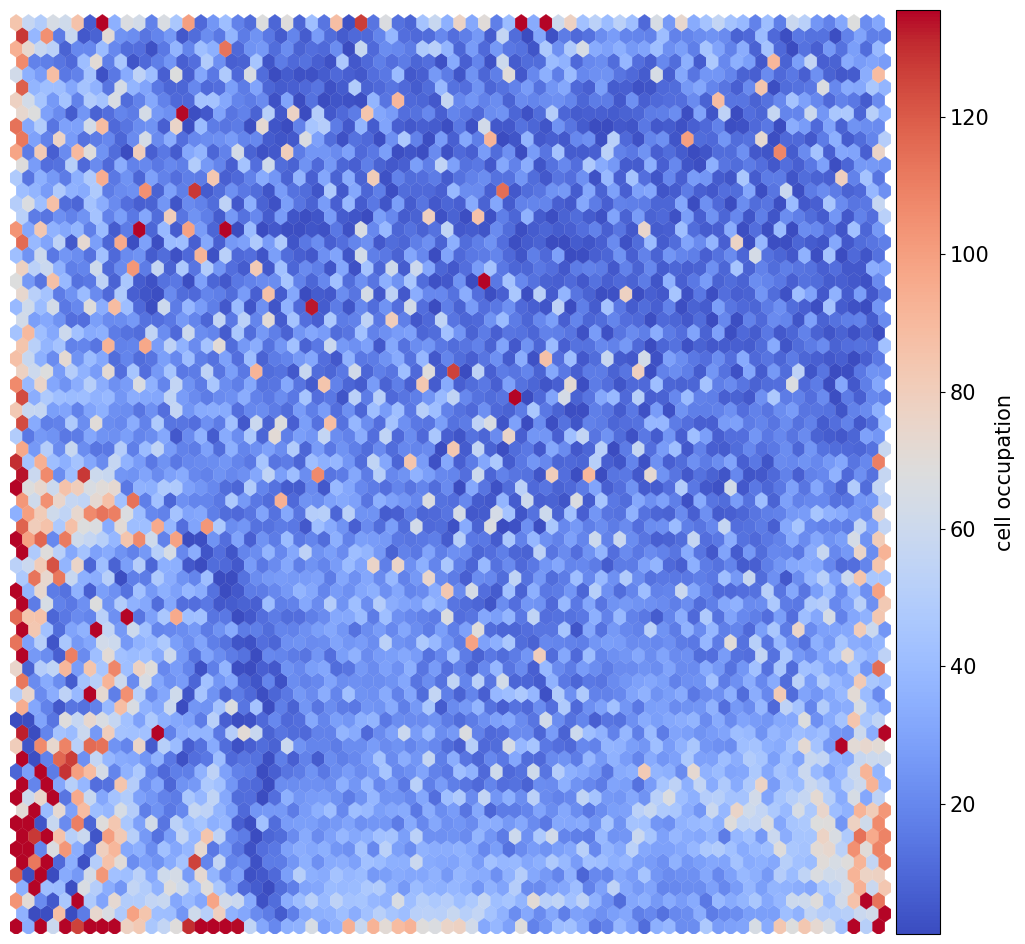

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
plot_som(ax, cellocc.T, grid_type=grid_type, colormap=cm.coolwarm, cbar_name='cell occupation')

And here is the mean redshift per cell:

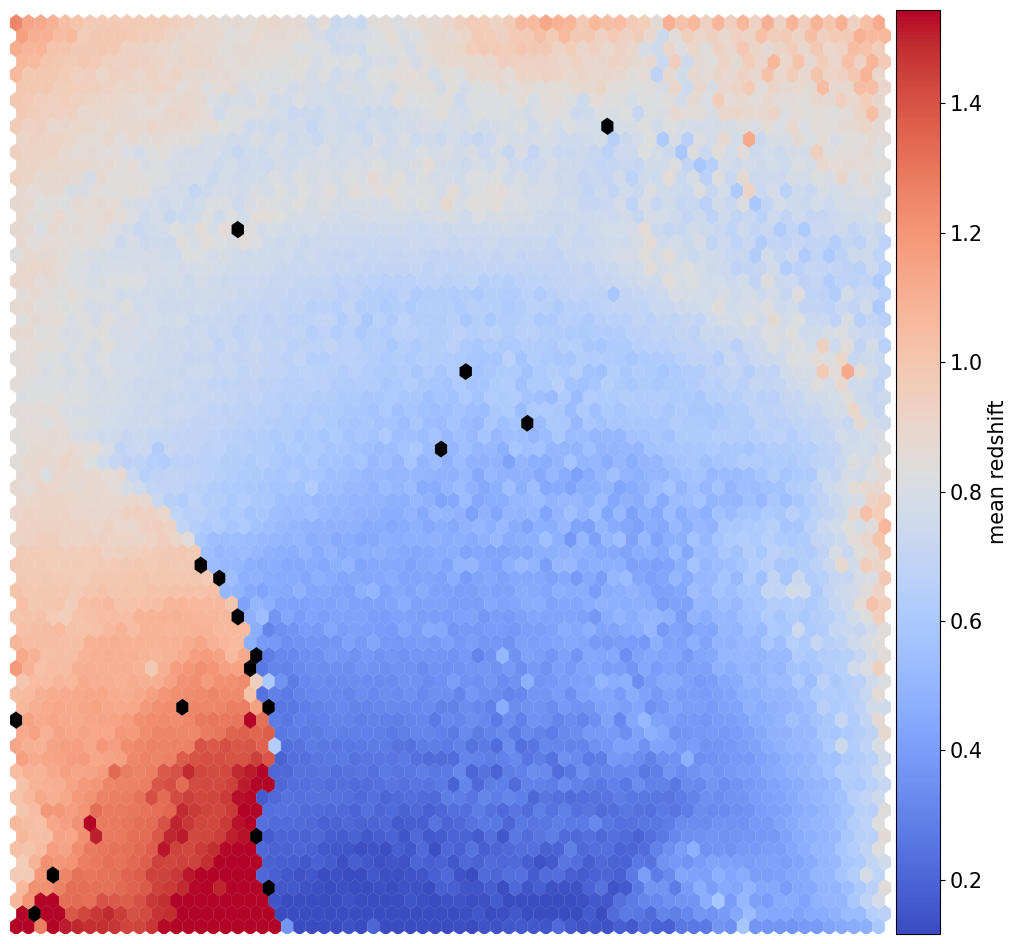

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
plot_som(ax, meanszs.T, grid_type=grid_type, colormap=cm.coolwarm, cbar_name='mean redshift')

Note that there is spatial correlation between redshift and cell position, which is good, this is showing how there are gradual changes in redshift between similarly-colored galaxies (and sometimes abrupt changes, when degeneracies are present).

Now that we have illustrated what exactly we have constructed, let's use the SOM to predict the redshift distribution for a set of photometric objects.  We will make a simple cut in spectroscopic redshift to create a compact redshift bin.  In more realistic circumstances we would likely be using color cuts or photometric redshift estimates to define our test bin(s).  We will cut our photometric sample to only include galaxies in 0.5<specz<0.9.

We will need to trim both our spec-z set to i<23.5 to match our trained SOM:

In [16]:
testfile = find_rail_file('examples_data/testdata/test_dc2_training_9816.hdf5')
data = tables_io.read(testfile)['photometry']
mask = ((data['redshift'] > 0.2) & (data['redshift']<0.5))
brightmask = ((mask) & (data['mag_i_lsst']<23.5))
trim_data = {}
bright_data = {}
for key in data.keys():
    trim_data[key] = data[key][mask]
    bright_data[key] = data[key][brightmask]
trimdict = dict(photometry=trim_data)
brightdict = dict(photometry=bright_data)
# add data to data store
test_data = DS.add_data("tomo_bin", trimdict, TableHandle)
bright_data = DS.add_data("bright_bin", brightdict, TableHandle)

In [17]:
specfile = find_rail_file("examples_data/testdata/test_dc2_validation_9816.hdf5")
spec_data = tables_io.read(specfile)['photometry']
smask = (spec_data['mag_i_lsst'] <23.5)
trim_spec = {}
for key in spec_data.keys():
    trim_spec[key] = spec_data[key][smask]
trim_dict = dict(photometry=trim_spec)
spec_data = DS.add_data("spec_data", trim_dict, TableHandle)

Note that we have removed the 'photometry' group, we will specify the `phot_groupname` as "" in the parameters below.

As before, let us specify our initialization params for the SomocluSOMSummarizer stage, including:

- `model`: name of the pickled model that we created, in this case "output_SOM_model.pkl"
- `hdf5_groupname` (str): hdf5 group for our photometric data (in our case "")
- `objid_name` (str): string specifying the name of the ID column, if present photom data, will be written out to cellid_output file
- `spec_groupname` (str): hdf5 group for the spectroscopic data
- `nzbins` (int): number of bins to use in our histogram ensemble
- `nsamples` (int): number of bootstrap samples to generate
- `output` (str): name of the output qp file with N samples
- `single_NZ` (str): name of the qp file with fiducial distribution
- `uncovered_cell_file` (str): name of hdf5 file containing a list of all of the cells with phot data but no spec-z objects: photometric objects in these cells will *not* be accounted for in the final N(z), and should really be removed from the sample before running the summarizer.  Note that we return a single integer that is constructed from the pairs of SOM cell indices via `np.ravel_multi_index`(indices).

In [18]:
summ_dict = dict(model="output_SOMoclu_model.pkl", hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=25,
                 output='SOM_ensemble.hdf5', single_NZ='fiducial_SOMoclu_NZ.hdf5',
                 uncovered_cell_file='all_uncovered_cells.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs.hdf5')

Now let's initialize and run the summarizer.  One feature of the SOM: if any SOM cells contain photometric data but do not contain any redshifts values in the spectroscopic set, then no reasonable redshift estimate for those objects is defined, and they are skipped.  The method currently prints the indices of uncovered cells, we may modify the algorithm to actually output the uncovered galaxies in a separate file in the future.

In [19]:
som_summarizer = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer', **summ_dict)

In [20]:
som_summarizer.summarize(test_data, spec_data)

Inserting handle into data store.  model: output_SOMoclu_model.pkl, SOMoclu_summarizer
Process 0 running summarizer on chunk 0 - 1545
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{2561, 4099, 8, 2057, 4106, 4616, 2569, 4618, 2571, 2063, 16, 522, 3593, 2067, 3600, 2581, 3601, 2073, 4633, 4123, 27, 4125, 3609, 2592, 3619, 3108, 4133, 4135, 4647, 3113, 2603, 3629, 2606, 4655, 3631, 4149, 4662, 3641, 3132, 4670, 4671, 4672, 4163, 3652, 3142, 2635, 2638, 3152, 4692, 4693, 2647, 2648, 2137, 2649, 4697, 4698, 1629, 4088, 4193, 2146, 4196, 3172, 3690, 4204, 2669, 3180, 2159, 4719, 4721, 2162, 3694, 1649, 3703, 1146, 4733, 1662, 2688, 4226, 2182, 4743, 1160, 4235, 4748, 2189, 3723, 4239, 4240, 2704, 4242, 2708, 1688, 4766, 4768, 4769, 4772, 4265, 4266, 4778, 4268, 3245, 1199, 3248, 4785, 3762, 2227, 1206, 4281, 2237, 4797, 3264, 3781, 2247, 4807,

NOTE/WARNING: Expected output file uncovered_cluster_file_SOMoclu_summarizer was not generated.


Let's open the fiducial N(z) file, plot it, and see how it looks, and compare it to the true tomographic bin file:

In [21]:
fid_ens = qp.read("fiducial_SOMoclu_NZ.hdf5")

In [22]:
def get_cont_hist(data, bins):
    hist, bin_edge = np.histogram(data, bins=bins, density=True)
    return hist, (bin_edge[1:]+bin_edge[:-1])/2

In [23]:
test_nz_hist, zbin = get_cont_hist(test_data.data['photometry']['redshift'], np.linspace(0,3,101))
som_nz_hist = np.squeeze(fid_ens.pdf(zbin))

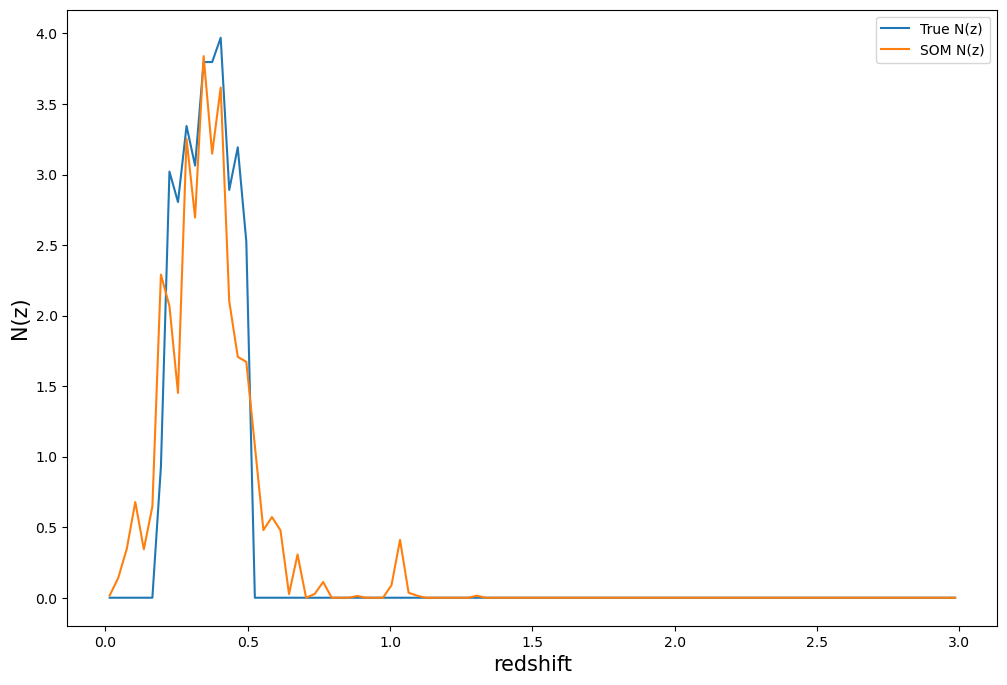

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_xlabel("redshift", fontsize=15)
ax.set_ylabel("N(z)", fontsize=15)
ax.plot(zbin, test_nz_hist, label='True N(z)')
ax.plot(zbin, som_nz_hist, label='SOM N(z)')
plt.legend()

Seems fine, roughly the correct redshift range for the lower redshift peak, but a few secondary peaks at large z tail.  What if we try the bright dataset that we made?

In [25]:
bright_dict = dict(model="output_SOMoclu_model.pkl", hdf5_groupname='photometry',
                   spec_groupname='photometry', nzbins=101, nsamples=25,
                   output='BRIGHT_SOMoclu_ensemble.hdf5', single_NZ='BRIGHT_fiducial_SOMoclu_NZ.hdf5',
                   uncovered_cell_file="BRIGHT_uncovered_cells.hdf5",
                   objid_name='id',
                   cellid_output='BRIGHT_output_cellIDs.hdf5')
bright_summarizer = SOMocluSummarizer.make_stage(name='bright_summarizer', **bright_dict)

In [26]:
bright_summarizer.summarize(bright_data, spec_data)

Process 0 running summarizer on chunk 0 - 645
Inserting handle into data store.  cellid_output_bright_summarizer: inprogress_BRIGHT_output_cellIDs.hdf5, bright_summarizer
the following clusters contain photometric data but not spectroscopic data:
{4616, 2569, 4106, 4618, 3593, 3600, 4633, 3609, 2592, 3619, 4133, 4647, 2603, 3631, 4149, 4670, 4672, 4163, 3652, 3142, 2638, 3152, 4692, 2647, 2137, 4697, 4193, 4196, 3172, 3690, 4204, 3694, 4721, 2162, 3703, 4733, 1662, 2688, 4226, 2182, 4743, 1160, 3723, 4748, 2189, 4240, 2704, 2708, 4768, 4266, 3248, 4785, 2237, 4797, 3781, 4807, 3274, 3786, 2769, 2776, 2272, 2785, 4839, 4339, 3315, 2293, 4342, 2805, 4855, 3842, 2819, 4359, 4874, 4364, 4878, 1295, 2323, 3862, 2327, 3870, 4896, 2339, 3883, 3888, 4915, 1333, 3383, 4408, 2364, 4933, 3912, 3920, 4434, 2906, 3933, 3423, 4449, 2919, 3432, 4968, 4468, 1396, 3958, 1912, 2428, 1918, 1924, 5002, 5006, 3982, 3472, 5014, 3996, 4509, 2463, 2975, 5024, 4000, 4515, 2980, 4517, 5039, 2487, 3519, 4031, 30

NOTE/WARNING: Expected output file uncovered_cluster_file_bright_summarizer was not generated.


In [27]:
bright_fid_ens = qp.read("BRIGHT_fiducial_SOMoclu_NZ.hdf5")

In [28]:
bright_nz_hist, zbin = get_cont_hist(bright_data.data['photometry']['redshift'], np.linspace(0,3,101))
bright_som_nz_hist = np.squeeze(bright_fid_ens.pdf(zbin))

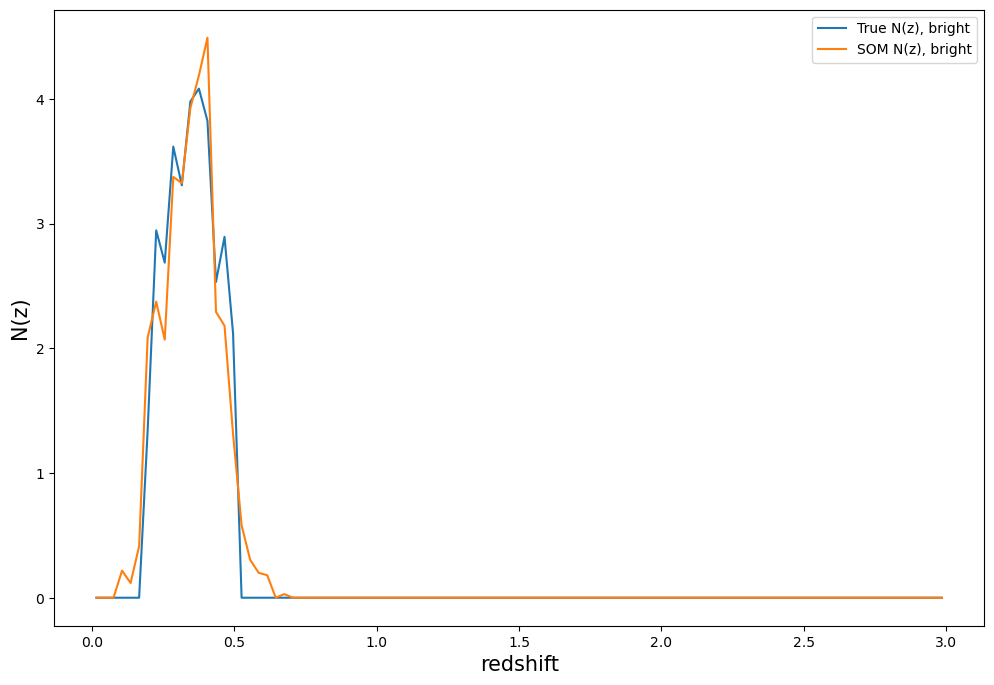

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_xlabel("redshift", fontsize=15)
ax.set_ylabel("N(z)", fontsize=15)
ax.plot(zbin, bright_nz_hist, label='True N(z), bright')
ax.plot(zbin, bright_som_nz_hist, label='SOM N(z), bright')
plt.legend()

Looks better, we've eliminated the secondary peak. Now, SOMs are a bit touchy to train, and are highly dependent on the dataset used to train them.  This demo used a relatively small dataset (~150,000 DC2 galaxies from one healpix pixel) to train the SOM, and even smaller photometric and spectroscopic datasets of 10,000 and 20,000 galaxies.  We should expect slightly better results with more data, at least in cells where the spectroscopic data is representative.

However, there is a caveat that SOMs are not guaranteed to converge, and are very sensitive to both the input data and tunable parameters of the model.  So, users should do some verification tests before trusting the SOM is going to give accurate results.

Finally, let's load up our bootstrap ensembles and overplot N(z) of bootstrap samples:

In [30]:
boot_ens = qp.read("BRIGHT_SOMoclu_ensemble.hdf5")

/tmp/ipykernel_1220910/4031386170.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=13);


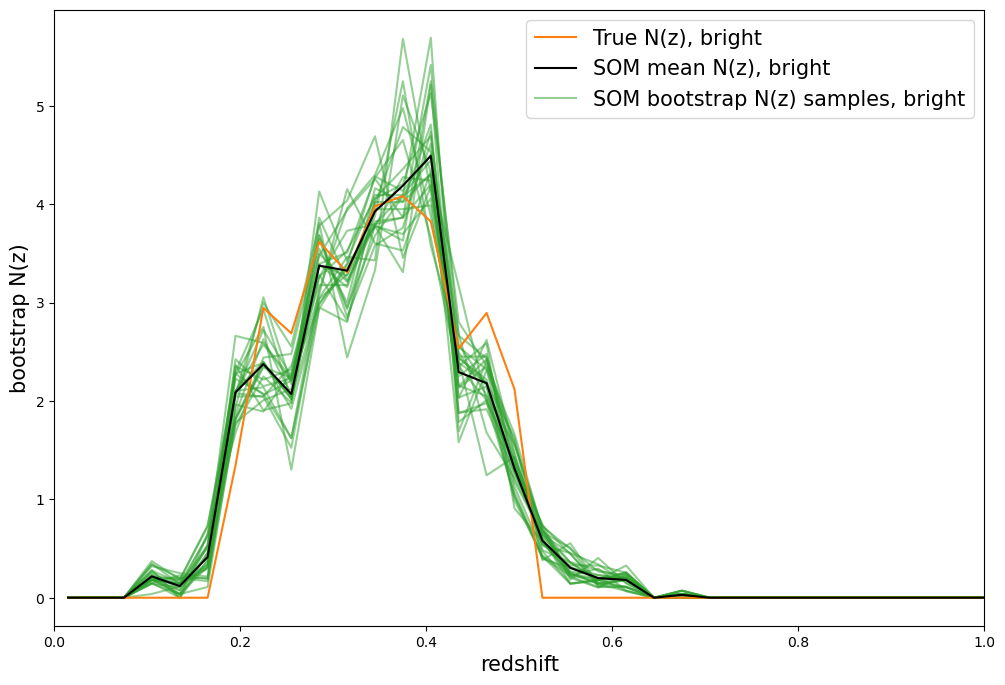

In [31]:
fig, ax=plt.subplots(1,1,figsize=(12, 8))
ax.set_xlim((0,1))
ax.set_xlabel("redshift", fontsize=15)
ax.set_ylabel("bootstrap N(z)", fontsize=15)
ax.legend(loc='upper right', fontsize=13);

ax.plot(zbin, bright_nz_hist, label='True N(z), bright', color='C1', zorder=1)
ax.plot(zbin, bright_som_nz_hist, label='SOM mean N(z), bright', color='k', zorder=2)

for i in range(boot_ens.npdf):
    #ax = plt.subplot(2,3,i+1)
    pdf = np.squeeze(boot_ens[i].pdf(zbin))
    if i == 0:        
        ax.plot(zbin, pdf, color='C2',zorder=0, alpha=0.5, label='SOM bootstrap N(z) samples, bright')
    else:
        ax.plot(zbin, pdf, color='C2',zorder=0, alpha=0.5)
    #boot_ens[i].plot_native(axes=ax, label=f'SOM bootstrap {i}')
plt.legend(fontsize=15)

## Quantitative metrics

Let's look at how we've done at estimating the mean redshift and "width" (via standard deviation) of our tomographic bin compared to the true redshift and "width" for both our "full" sample and "bright" i<23.5 samples.  We will plot the mean and std dev for the full and bright distributions compared to the true mean and width, and show the Gaussian uncertainty approximation given the scatter in the bootstraps for the mean:

In [32]:
from scipy.stats import norm

In [33]:
full_ens = qp.read("SOM_ensemble.hdf5")
full_means = full_ens.mean().flatten()
full_stds = full_ens.std().flatten()
true_full_mean = np.mean(test_data.data['photometry']['redshift'])
true_full_std = np.std(test_data.data['photometry']['redshift'])
# mean and width of bootstraps
full_mu = np.mean(full_means)
full_sig = np.std(full_means)
full_norm = norm(loc=full_mu, scale=full_sig)
grid = np.linspace(0, .7, 301)
full_uncert = full_norm.pdf(grid)*2.51*full_sig

Let's check the accuracy and precision of mean readshift:

In [34]:
print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(full_means),4)) + '+-' + str(round(np.std(full_means),4)))
print("The mean redshift of the real data is: "+str(round(true_full_mean,4)))
print("The bias of mean redshift is:"+str(round(np.mean(full_means)-true_full_mean,4)) + '+-' + str(round(np.std(full_means),4)))

The mean redshift of the SOM ensemble is: 0.3589+-0.0053
The mean redshift of the real data is: 0.3547
The bias of mean redshift is:0.0042+-0.0053


In [35]:
bright_means = boot_ens.mean().flatten()
bright_stds = boot_ens.std().flatten()
true_bright_mean = np.mean(bright_data.data['photometry']['redshift'])
true_bright_std = np.std(bright_data.data['photometry']['redshift'])
bright_uncert = np.std(bright_means)
# mean and width of bootstraps
bright_mu = np.mean(bright_means)
bright_sig = np.std(bright_means)
bright_norm = norm(loc=bright_mu, scale=bright_sig)
bright_uncert = bright_norm.pdf(grid)*2.51*bright_sig

In [36]:
print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(bright_means),4)) + '+-' + str(round(np.std(bright_means),4)))
print("The mean redshift of the real data is: "+str(round(true_bright_mean,4)))
print("The bias of mean redshift is:"+str(round(np.mean(bright_means)-true_bright_mean, 4)) + '+-' + str(round(np.std(bright_means),4)))

The mean redshift of the SOM ensemble is: 0.3445+-0.0035
The mean redshift of the real data is: 0.3493
The bias of mean redshift is:-0.0048+-0.0035


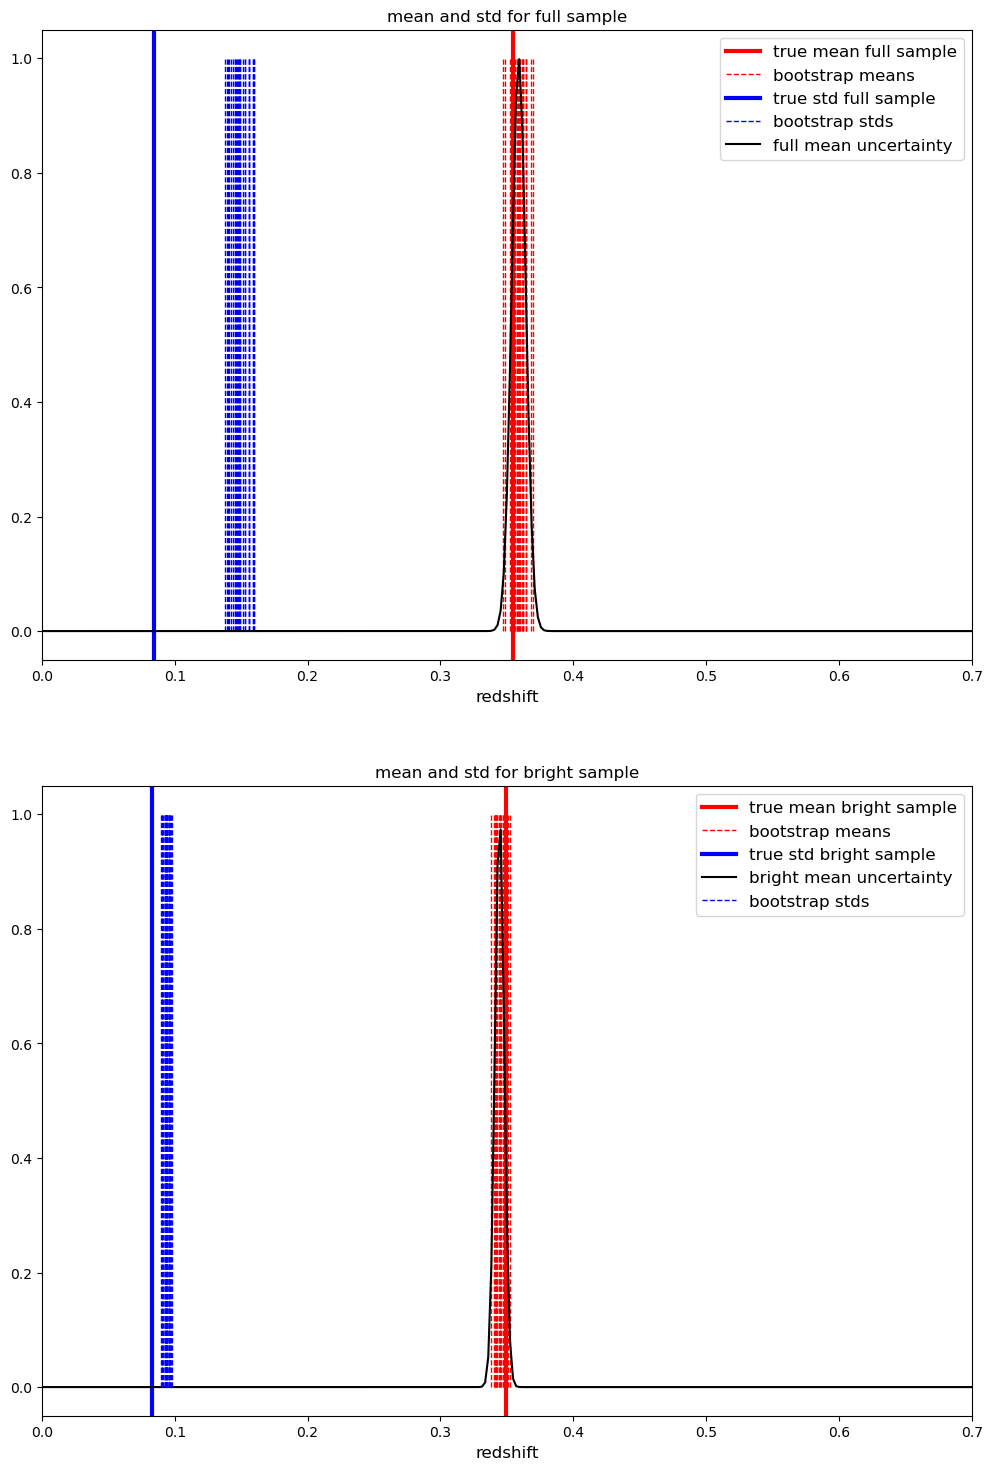

In [37]:
plt.figure(figsize=(12,18))
ax0 = plt.subplot(2, 1, 1)
ax0.set_xlim(0.0, 0.7)
ax0.axvline(true_full_mean, color='r', lw=3, label='true mean full sample')
ax0.vlines(full_means, ymin=0, ymax=1, color='r', ls='--', lw=1, label='bootstrap means')
ax0.axvline(true_full_std, color='b', lw=3, label='true std full sample')
ax0.vlines(full_stds, ymin=0, ymax=1, lw=1, color='b', ls='--', label='bootstrap stds')
ax0.plot(grid, full_uncert, c='k', label='full mean uncertainty')
ax0.legend(loc='upper right', fontsize=12)
ax0.set_xlabel('redshift', fontsize=12)
ax0.set_title('mean and std for full sample', fontsize=12)

ax1 = plt.subplot(2, 1, 2)
ax1.set_xlim(0.0, 0.7)
ax1.axvline(true_bright_mean, color='r', lw=3, label='true mean bright sample')
ax1.vlines(bright_means, ymin=0, ymax=1, color='r', ls='--', lw=1, label='bootstrap means')
ax1.axvline(true_bright_std, color='b', lw=3, label='true std bright sample')
ax1.plot(grid, bright_uncert, c='k', label='bright mean uncertainty')
ax1.vlines(bright_stds, ymin=0, ymax=1, ls='--', lw=1, color='b', label='bootstrap stds')
ax1.legend(loc='upper right', fontsize=12)
ax1.set_xlabel('redshift', fontsize=12)
ax1.set_title('mean and std for bright sample', fontsize=12);

For both cases, the mean redshifts seem to be pretty precise and accurate (bright sample seems more precise). For the full sample, the SOM N(z) are slightly wider, while for the bright sample the widths are also fairly accurate.
For both cases, the errors in mean redshift are at levels of ~0.005, close to the tolerance for cosmological analysis. However, we have not consider the photometric error in magnitudes and colors, as well as additional color selections. Our sample is also limited. This demo only serves as a preliminary implementation of SOM in RAIL.